# EDA Notebook
This notebook provides quick exploratory checks to preview the dataset and examine missing values.
It will try common locations for the CSV and load the first one it finds (project `data/sample.csv` is preferred).

In [1]:
# Imports and helpers
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
sns.set(style="whitegrid")

# Try a list of likely paths (project data/ first, then parent, then downloads)
candidates = [
    os.path.join(os.getcwd(), 'data', 'sample.csv'),
    os.path.join(os.getcwd(), '..', 'data', 'sample.csv'),
    os.path.expanduser('~/Downloads/Visadataset.csv'),
    'C:/Users/Maduka/Downloads/Visadataset.csv'
]
path = None
for p in candidates:
    if p and os.path.exists(p):
        path = p
        break

if path is None:
    raise FileNotFoundError(f'Could not find dataset in candidates: {candidates}')

print('Loading dataset from:', path)
# Use a robust read to avoid early failures on messy rows
df = pd.read_csv(path, low_memory=False, on_bad_lines='skip')
print('Loaded. shape=', df.shape)

Loading dataset from: c:\Users\Maduka\OneDrive\Documents\USvisaProject\visa_classifier\notebooks\..\data\sample.csv
Loaded. shape= (25480, 12)


## Cell Insight — Data loading and imports

- Purpose: import commonly-used EDA libraries and load the dataset from likely locations.
- Why this approach: using a short list of candidate paths keeps the notebook robust across environments; `low_memory=False` and `on_bad_lines='skip'` avoid parse failures on messy CSV files.
- Basic insight: if this cell runs successfully, the dataset is available as `df` and you can proceed with lightweight checks and visualizations.

In [4]:
# Preview the data
display(df.head())
print('Columns ({}):'.format(len(df.columns)))
print(df.columns.tolist())

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


Columns (12):
['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'yr_of_estab', 'region_of_employment', 'prevailing_wage', 'unit_of_wage', 'full_time_position', 'case_status']


## Cell Insight — Data preview

- Purpose: display the first rows and list columns to get an immediate sense of the dataset structure and column names.
- Why this approach: a quick head() view helps identify messy headers, obvious missing values, or mis-typed columns before further analysis.
- Basic insight: use the printed column list to decide which columns are likely numeric, categorical, or target candidates.

In [5]:
# Data types and non-null counts
display(df.dtypes)
print(f"\nNon-null counts:")
display(df.count())

case_id                   object
continent                 object
education_of_employee     object
has_job_experience        object
requires_job_training     object
no_of_employees            int64
yr_of_estab                int64
region_of_employment      object
prevailing_wage          float64
unit_of_wage              object
full_time_position        object
case_status               object
dtype: object


Non-null counts:


case_id                  25480
continent                25480
education_of_employee    25480
has_job_experience       25480
requires_job_training    25480
no_of_employees          25480
yr_of_estab              25480
region_of_employment     25480
prevailing_wage          25480
unit_of_wage             25480
full_time_position       25480
case_status              25480
dtype: int64

## Cell Insight — Data types and non-null counts

- Purpose: surface each column's dtype and the counts of non-null values.
- Why this approach: dtypes and non-null counts reveal parsing issues (numbers stored as strings), and columns with many nulls which may need special handling.
- Basic insight: focus on columns where non-null counts are much lower than the dataset length; these may need imputation or exclusion.

In [7]:
# Missing value summary
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_summary = pd.DataFrame({'count': missing_counts, 'percent': missing_pct}).sort_values('count', ascending=False)
display(missing_summary[missing_summary['count']>0])

,count,percent


## Cell Insight — Missing value summary

- Purpose: compute missing counts and percentages per column and show columns with at least one missing value.
- Why this approach: quickly identifies columns requiring imputation, removal, or special treatment; sorting by count focuses attention on the largest problems first.
- Basic insight: use the `missing_summary` output to select columns for imputation, dropping, or further visualization (e.g., how missingness correlates with the target).

In [8]:
# Show columns with missing values
cols_missing = missing_summary[missing_summary['count']>0].index.tolist()
print('Columns with missing values:', cols_missing)

Columns with missing values: []


## Cell Insight — Columns with missing values

- Purpose: list which columns have missing values (derived from `missing_summary`).
- Why this approach: a compact list is easier to scan than a full table; good for deciding which variables to inspect further or include in downstream imputation logic.
- Basic insight: next steps typically include plotting missingness patterns by column and cross-tabulating missingness against the target.

In [9]:
# Visualize missingness heatmap for columns with missing values 
if cols_missing:
    sample_df = df[cols_missing] if len(df)<=5000 else df[cols_missing].sample(5000, random_state=0)
    plt.figure(figsize=(min(12, len(cols_missing)*0.5+3), 6))
    sns.heatmap(sample_df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing values heatmap (sample)')
    plt.show()
else:
    print('No missing values found in dataset.')

No missing values found in dataset.


## Cell Insight — Missingness heatmap (sample)

- Purpose: visualize the pattern of missing values across rows and columns (sampled when large).
- Why this approach: heatmaps make it easy to see blocky missingness (e.g., whole columns missing for subsets) and identify correlated missingness between columns.
- Basic insight: if missingness clusters by row group, consider investigating data collection filters or merging steps; if columns are almost entirely missing, consider dropping them.

In [10]:
# Quick check for a typical target column (e.g., case_status) and its distribution
candidates = [c for c in df.columns if c.lower() in ('case_status','case outcome','case_outcome','status','decision')]
if candidates:
    tgt = candidates[0]
    print('Using target column:', tgt)
    display(df[tgt].value_counts(dropna=False).rename('count'))
    display(df[tgt].value_counts(normalize=True, dropna=False).rename('proportion').round(3))
else:
    print('No obvious target column found. Candidate columns to inspect:')
    print(df.columns.tolist()[:50])

Using target column: case_status


case_status
Certified    17018
Denied        8462
Name: count, dtype: int64

case_status
Certified    0.668
Denied       0.332
Name: proportion, dtype: float64

## Cell Insight — Target identification and quick distribution

- Purpose: automatically detect an obvious target column (common names) and show counts/proportions.
- Why this approach: saves time by programmatically picking likely target columns instead of manual inspection; showing both counts and proportions helps gauge class imbalance early.
- Basic insight: if the target is heavily imbalanced, consider balancing strategies or appropriate evaluation metrics (e.g., F1, PR-AUC). If no candidate is found, you can manually assign `tgt = '<column_name>'`.

C:\Users\Maduka\AppData\Local\Temp\ipykernel_24488\1095320310.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

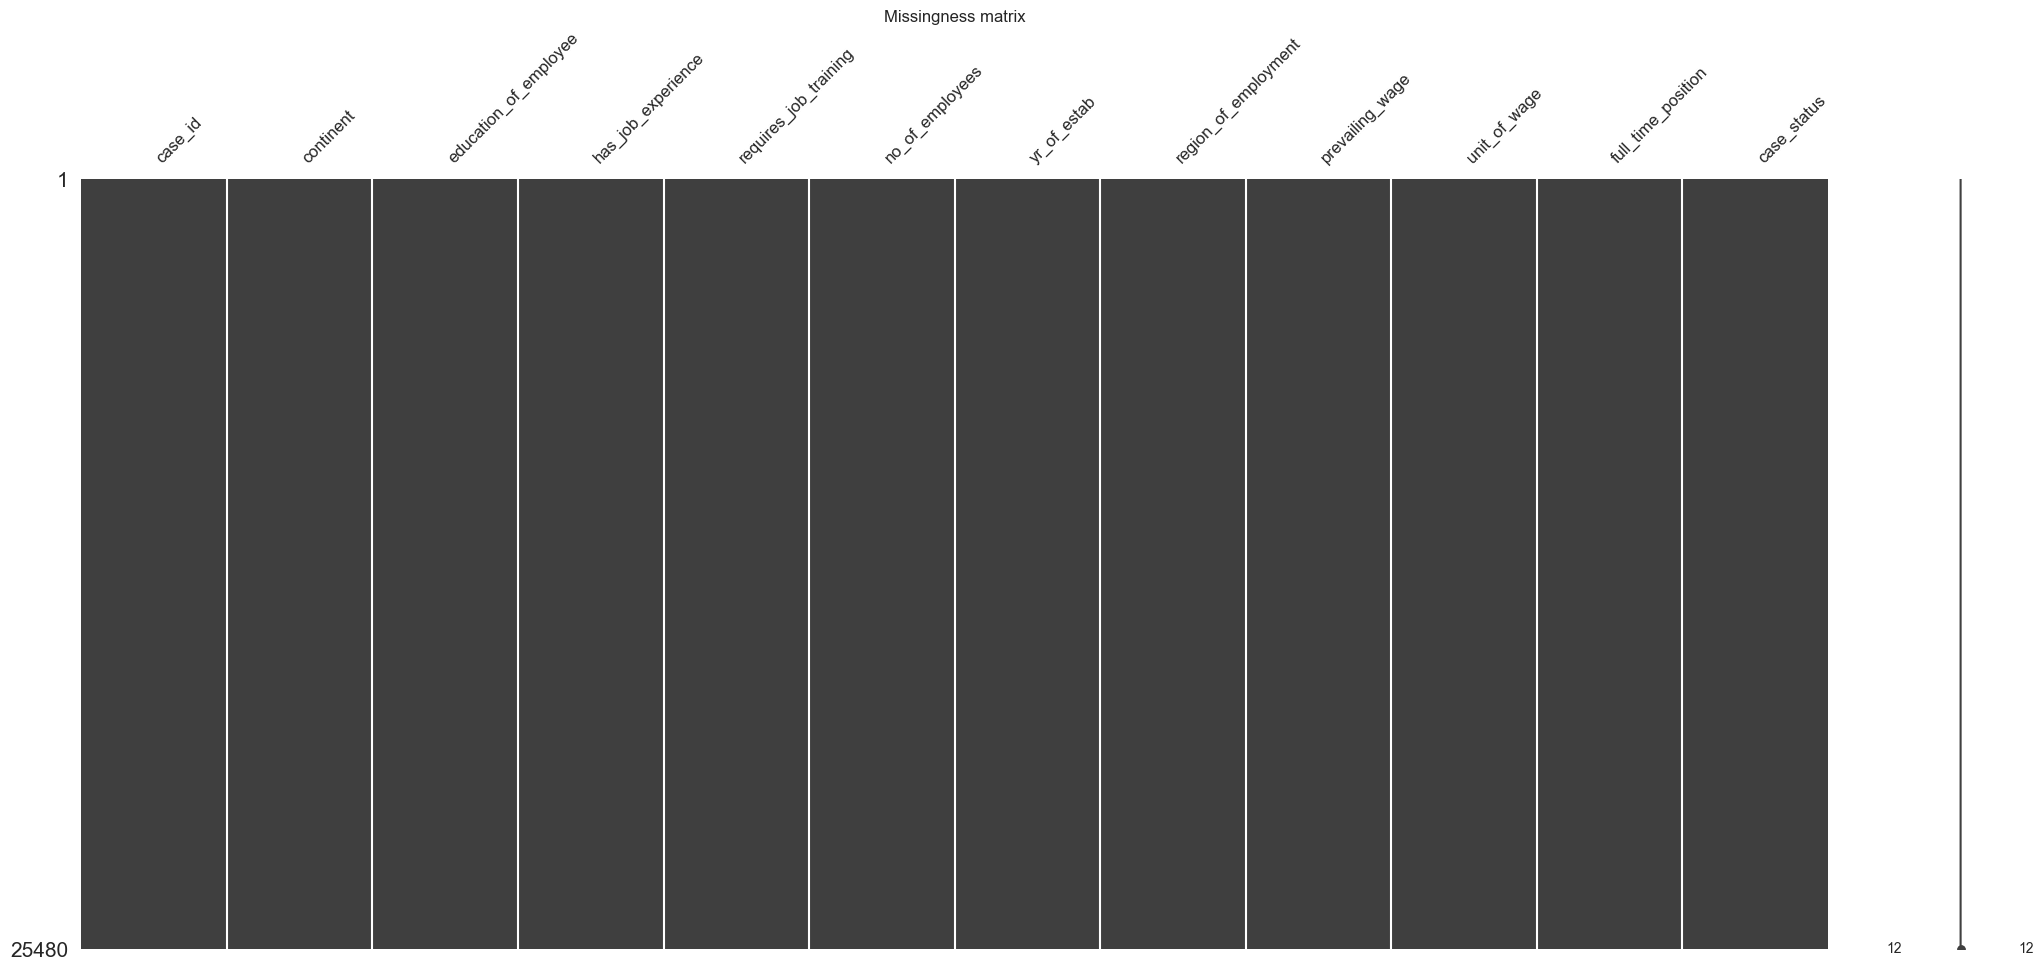

In [12]:
# Plot missingness using missingno (msno)
try:
    import missingno as msno
except Exception:
    msno = None

import matplotlib.pyplot as plt
import seaborn as sns

# Use existing `df` DataFrame from the notebook kernel
plt.figure(figsize=(10, 6))
if msno is not None:
    msno.matrix(df, fontsize=12)
    plt.title('Missingness matrix')
else:
    # Fallback: heatmap of missingness fraction per column
    sns.heatmap(df.isnull(), cbar=False)
    plt.title('Missingness heatmap (fallback)')

plt.tight_layout()
plt.show()

## Cell Insight — Missingness matrix (missingno) or fallback

- Purpose: provide a compact matrix-style visualization of missingness across the whole dataset.
- Why this approach: `missingno.matrix` is useful to quickly see overall completeness and row-level patterns; fallback heatmap is provided for environments without `missingno`.
- Basic insight: if missingness appears random, simple imputation may suffice; if it's structured, imputation by group or model may be needed.

C:\Users\Maduka\AppData\Local\Temp\ipykernel_24488\1015887501.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x=tgt, palette='Set2')


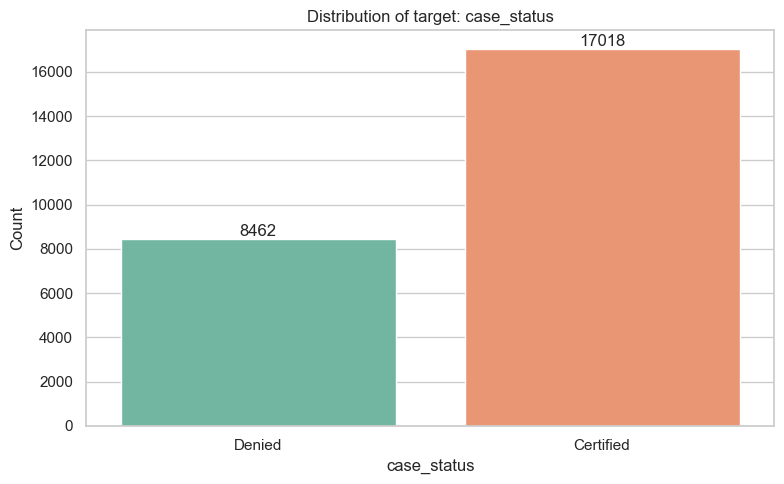

In [13]:
# Plot distribution of target variable
import matplotlib.pyplot as plt
import seaborn as sns

# Use `tgt` variable (string name of target column) and `df` DataFrame from kernel
if 'tgt' in globals() and tgt in df.columns:
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(data=df, x=tgt, palette='Set2')
    plt.title(f'Distribution of target: {tgt}')
    plt.ylabel('Count')
    plt.xlabel(tgt)

    # Annotate bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
else:
    print("Target variable `tgt` not found in kernel or not a column in `df`. Available columns:")
    print(df.columns.tolist())

## Cell Insight — Target distribution plot

- Purpose: visualize counts for each target class using a bar plot and annotate counts on bars.
- Why this approach: visual class distribution communicates imbalance more intuitively than raw numbers and helps decide stratification or resampling strategies.
- Basic insight: annotated bars provide exact counts; if many unique classes exist, consider grouping rare classes into "Other" for modeling.

In [14]:
# Compute counts and percentages for CERTIFIED vs DENIED (using normalize=True)
if 'tgt' in globals() and tgt in df.columns:
    counts = df[tgt].value_counts(dropna=False)
    pct = df[tgt].value_counts(normalize=True, dropna=False).mul(100).round(2)

    # Filter for CERTIFIED and DENIED (case-insensitive match)
    def get_count_label(label):
        matches = [k for k in counts.index if isinstance(k, str) and k.strip().lower()==label.lower()]
        if matches:
            k = matches[0]
            return counts[k], pct[k]
        return 0, 0.0

    certified_count, certified_pct = get_count_label('CERTIFIED')
    denied_count, denied_pct = get_count_label('DENIED')

    print(f"CERTIFIED: {certified_count} ({certified_pct}%)")
    print(f"DENIED:    {denied_count} ({denied_pct}%)")

    # Also show full table for reference
    display(pd.DataFrame({'count': counts, 'percent': pct}))
else:
    print("Target variable `tgt` not found or not a column in `df`.")
    print(df.columns.tolist())

CERTIFIED: 17018 (66.79%)
DENIED:    8462 (33.21%)


,count,percent
case_status,,
Certified,17018,66.79
Denied,8462,33.21


## Cell Insight — CERTIFIED vs DENIED counts & percentages

- Purpose: compute raw counts and normalized percentages (using `normalize=True`) for the two most important outcome classes.
- Why this approach: normalizing makes it trivial to understand class balance in percent form and compare across datasets of different sizes.
- Basic insight: use the printed counts and percentages to report results and to decide whether balancing is needed for modeling.

In [15]:
# Dataset overview: shape, info, dtypes, describe, numerical and categorical lists
print(f"Shape: {df.shape}")

print('\nInfo:')
# Show info() to stdout
import sys
_df_buf = []
print(df.info(buf=None))

print('\nDtypes:')
print(df.dtypes)

print('\nDescribe (numerical):')
print(df.describe(include=[np.number]).T)

# Numerical columns
num_cols = [c for c in df.columns if df[c].dtype in ["int64", "float64", "int32", "float32"]]
print(f"\nNumerical columns: {num_cols}")

# Categorical columns -> use list comprehension with if / not in
cat_cols = [c for c in df.columns if c not in num_cols and c not in [tgt] if df[c].dtype == 'object' or df[c].dtype.name=='category']
print(f"\nCategorical columns: {cat_cols}")

# Check high cardinality for categorical features (loop). Skip case_id.
print('\nHigh cardinality check (categorical features):')
for col in cat_cols:
    if col == 'case_id':
        continue
    n_unique = df[col].nunique(dropna=True)
    pct_unique = n_unique / len(df) * 100
    if n_unique > 50 or pct_unique > 50:
        print(f"Column {col}: high cardinality -> unique={n_unique} ({pct_unique:.2f}%)")
    else:
        print(f"Column {col}: unique={n_unique} ({pct_unique:.2f}%)")

Shape: (25480, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB
None

Dtypes:
case_id                   object
continent                 ob

## Cell Insight — Dataset overview and cardinality checks

- Purpose: summarize shape, dtypes, numerical summaries and list numerical/categorical columns; check categorical cardinality and skip obvious ID columns.
- Why this approach: building column lists programmatically speeds up downstream feature engineering and helps detect high-cardinality categorical features early (which affect encoding choices).
- Basic insight: pay attention to columns flagged as high-cardinality — these may require hashing, embedding, or dropping depending on modeling choices.

## High-level insights & recommended next steps

- Summarize key findings from the cells above: missingness patterns, target imbalance, and columns with high cardinality.
- Recommendations:
  - Impute or drop columns with excessive missingness.
  - If the target is imbalanced, plan for stratified splits, resampling, or metric choices robust to imbalance.
  - For high-cardinality categorical columns, consider frequency-binning, target encoding, or embeddings depending on model complexity.
- Next steps: create a small preprocessing pipeline that documents imputation strategies, categorical encoding choices, and a reproducible train/test split.

In [17]:
import os
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\Maduka\OneDrive\Documents\USvisaProject\visa_classifier\notebooks


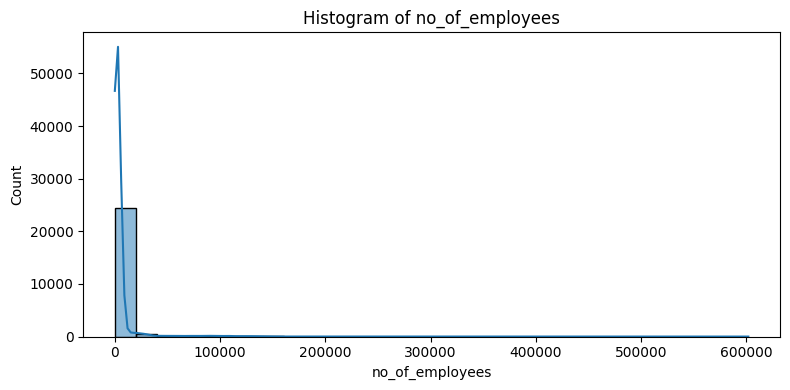

Observations for no_of_employees:
  mean = 5667.04
  median = 2109.00
  std = 22877.93
  missing = 0 (0.00%)
------------------------------------------------------------


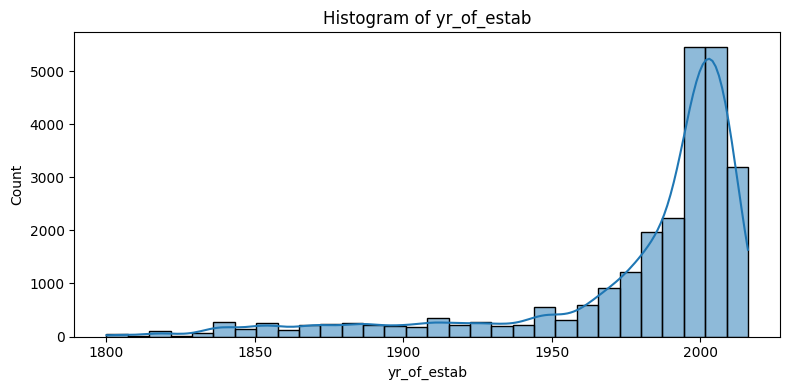

Observations for yr_of_estab:
  mean = 1979.41
  median = 1997.00
  std = 42.37
  missing = 0 (0.00%)
------------------------------------------------------------


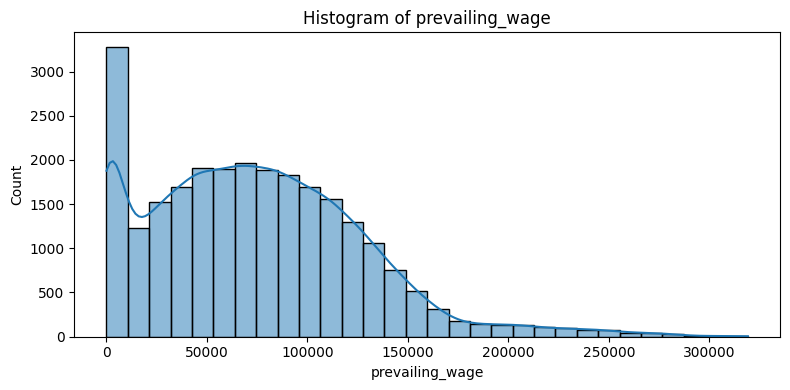

Observations for prevailing_wage:
  mean = 74455.81
  median = 70308.21
  std = 52815.94
  missing = 0 (0.00%)
------------------------------------------------------------


In [19]:
# Univariate analysis — numerical columns (first 3 numeric cols)
# Identify numerical columns

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('../data/sample.csv')

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_to_plot = num_cols[:3] if len(num_cols) else []

if not num_to_plot:
    print('No numerical columns detected.')
else:
    for col in num_to_plot:
        data = df[col].dropna()
        plt.figure(figsize=(8, 4))
        sns.histplot(data, kde=True, bins=30)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

        
        print(f"Observations for {col}:")
        print(f"  mean = {data.mean():.2f}")
        print(f"  median = {data.median():.2f}")
        print(f"  std = {data.std():.2f}")
        print(f"  missing = {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.2f}%)")
        print('-' * 60)
    


C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


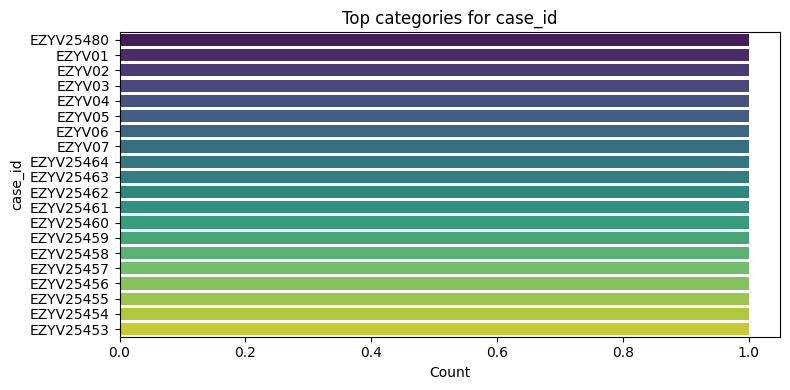

Observations for case_id:
  Unique values: 25480
  Top category: EZYV25480 (1 / 25480 = 0.00%)
  Note: High cardinality — consider grouping or encoding strategies.
------------------------------------------------------------


C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


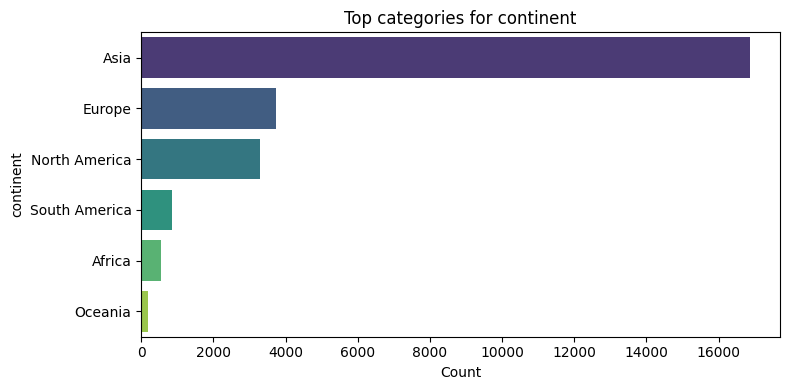

Observations for continent:
  Unique values: 6
  Top category: Asia (16861 / 25480 = 66.17%)
------------------------------------------------------------


C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


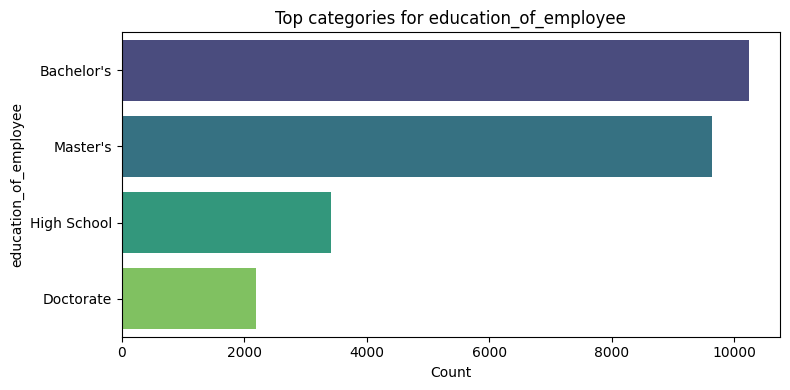

Observations for education_of_employee:
  Unique values: 4
  Top category: Bachelor's (10234 / 25480 = 40.16%)
------------------------------------------------------------


C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


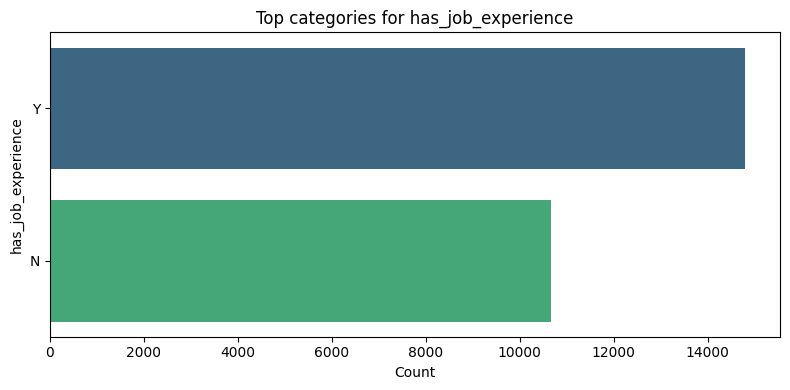

Observations for has_job_experience:
  Unique values: 2
  Top category: Y (14802 / 25480 = 58.09%)
------------------------------------------------------------


C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


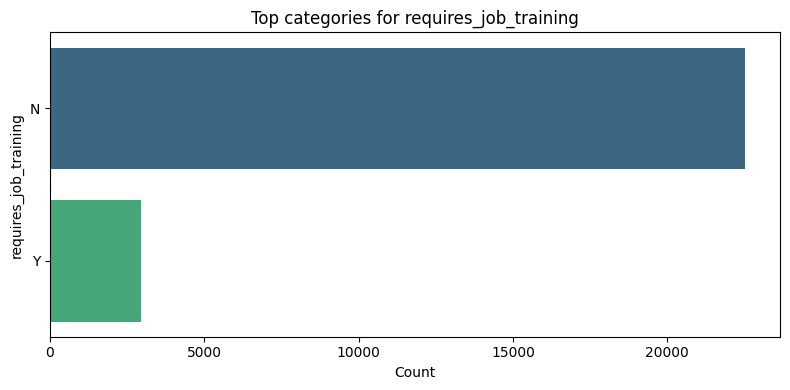

Observations for requires_job_training:
  Unique values: 2
  Top category: N (22525 / 25480 = 88.40%)
------------------------------------------------------------


C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


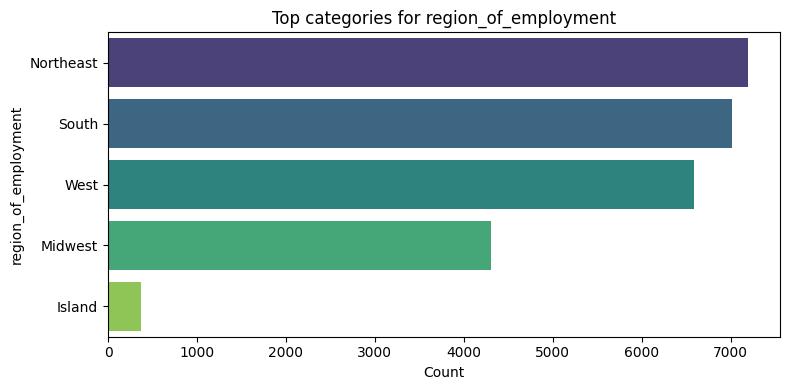

Observations for region_of_employment:
  Unique values: 5
  Top category: Northeast (7195 / 25480 = 28.24%)
------------------------------------------------------------


C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


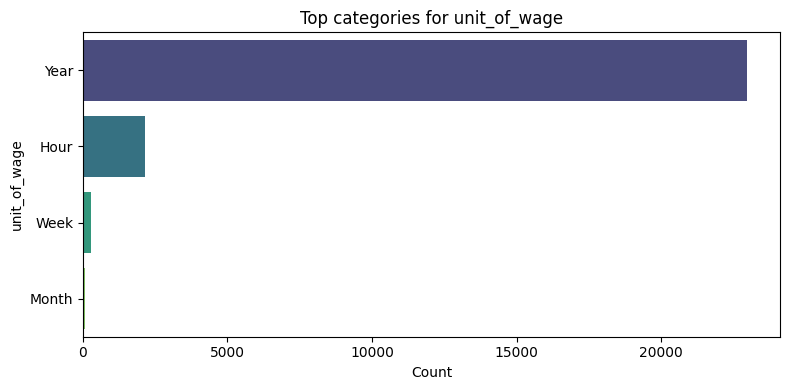

C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


Observations for unit_of_wage:
  Unique values: 4
  Top category: Year (22962 / 25480 = 90.12%)
------------------------------------------------------------


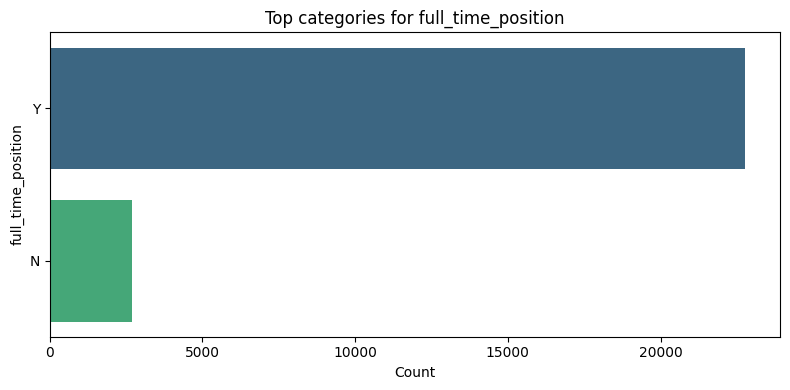

C:\Users\Maduka\AppData\Local\Temp\ipykernel_6908\316694279.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vc.values, y=vc.index, palette='viridis')


Observations for full_time_position:
  Unique values: 2
  Top category: Y (22773 / 25480 = 89.38%)
------------------------------------------------------------


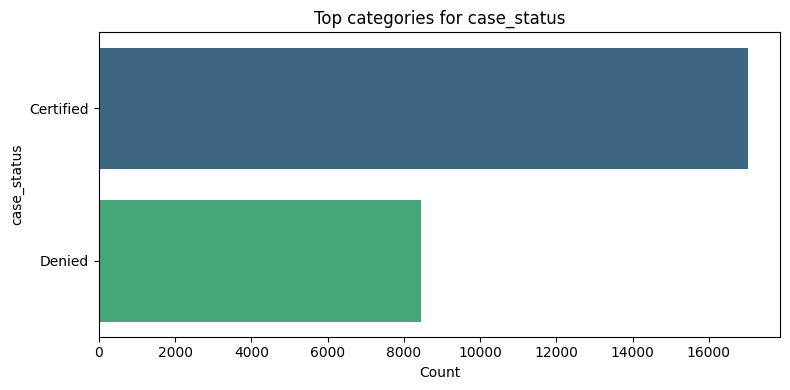

Observations for case_status:
  Unique values: 2
  Top category: Certified (17018 / 25480 = 66.79%)
------------------------------------------------------------


In [21]:

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Univariate analysis — categorical columns
if not cat_cols:
    print('No categorical columns detected.')
else:
    for col in cat_cols:
        plt.figure(figsize=(8, 4))

        vc = df[col].value_counts(dropna=False).head(20)

        
        sns.barplot(x=vc.values, y=vc.index, palette='viridis')
        plt.title(f'Top categories for {col}')
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

        n_unique = df[col].nunique(dropna=True)
        top = vc.index[0]
        top_count = vc.iloc[0]
        total = len(df)

        print(f"Observations for {col}:")
        print(f"  Unique values: {n_unique}")
        print(f"  Top category: {top} ({top_count} / {total} = {top_count / total * 100:.2f}%)")

        if n_unique > 50:
            print('  Note: High cardinality — consider grouping or encoding strategies.')

        print('-' * 60)


In [ ]:
# Multicollinearity check (Chi-squared test of independence) against target
from scipy.stats import chi2_contingency
import numpy as np
from IPython.display import display

alpha = 0.005  # significance threshold

# Check that target is defined and exists in DataFrame
if 'tgt' not in globals() or tgt not in df.columns:
    raise ValueError('Target variable `tgt` not set or not in df. Run target detection cell first.')

results = []

for col in df.columns:
    if col in [tgt, 'case_id']:
        continue

    series = df[col]

    # Convert numeric columns into categorical via binning if needed
    if pd.api.types.is_numeric_dtype(series):
        n_unique = series.nunique(dropna=True)
        if n_unique > 10:
            try:
                cat = pd.qcut(series, q=4, duplicates='drop').astype(str)
            except ValueError as e:
                print(f"Skipping {col}: could not bin numeric column — {e}")
                continue
        else:
            cat = series.astype(str)
    else:
        cat = series.astype(str)

    # Fill missing values
    cat = cat.fillna('<<MISSING>>')
    target_col = df[tgt].fillna('<<MISSING>>')

    # Create contingency table
    contingency = pd.crosstab(cat, target_col)

    # Ensure table is large enough for chi2
    if contingency.shape[0] < 2 or contingency.shape[1] < 2:
        print(f"Skipping {col}: contingency table too small (shape={contingency.shape})")
        continue

    try:
        chi2, p, dof, expected = chi2_contingency(contingency)
    except Exception as e:
        print(f"Could not run chi2 for {col}: {e}")
        continue

    # Output
    print('\n' + '=' * 80)
    print(f'Column: {col}')
    print(f'Contingency shape: {contingency.shape}')
    display(contingency)
    print(f'chi2 = {chi2:.4f}, p = {p:.6f}, dof = {dof}, expected shape = {np.array(expected).shape}')

    if p > alpha:
        print(f"✅ Decision (p > {alpha}): ACCEPT hypothesis that '{col}' affects {tgt}")
    else:
        print(f"❌ Decision (p <= {alpha}): REJECT hypothesis that '{col}' affects {tgt}")

    results.append({
        'column': col,
        'chi2': chi2,
        'p': p,
        'dof': dof,
        'contingency_shape': contingency.shape
    })

# Summary
res_df = pd.DataFrame(results).sort_values('p')

print('\n📊 Summary (sorted by p-value):')
display(res_df)


ValueError: Target variable `tgt` not set or not in df. Run target detection cell first.